In [1]:
%pylab notebook
from glob import glob

def draw(gid, x_o=0, y_o=0, bb=False):
    ''' draw a glyp at certain position '''
    gg = glyphs[gid]
#     w = gg[-1]
    
    l, r = gg[0:2]
    xx = gg[0::2][1:].astype(float)
    yy = gg[1::2][1:].astype(float)
    
    g_inds = (xx == -50) & (yy == 0)
    xx[g_inds] = nan
    yy[g_inds] = nan
    
    x_o -= l
    
    plot(xx + x_o, -yy + y_o, '-')
    if bb:
        vlines([0 + x_o], y_o - 20, y_o - 15, color='red')
        vlines([l + x_o], y_o - 20, y_o - 15, color='grey')
        vlines([r + x_o], y_o - 20, y_o - 15, color='grey')
    return r - l

def expand_range(mm):
    ''' expand a font mapping containing ranges '''
    if type(mm) is str:
        mm = mm.replace('\n', ' ').split()
    mm_ = []
    for m in mm:
        if '-' in m:
            tmp = m.split('-')
            rr = range(int(tmp[0]), int(tmp[1]) + 1)
            mm_ += rr
        else:
            mm_.append(int(m))
    return mm_

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Load hershey glyphs

In [2]:
with open('./hershey') as f:
    lines_ = f.readlines()

lines = []
for d in lines_:
    d = d.rstrip('\n')
    try:
        k = int(d[0:5])  # glyph id
        n = int(d[5:8])  # number of vertices
        lines.append(d)
    except ValueError:
        if len(d) > 0:
            lines[-1] += d
print(len(lines_), len(lines))

glyphs = {}
for d in lines:
    k = int(d[0:5])  # glyph id
    n = int(d[5:8])  # number of vertices
    tmp = [ord(c) - ord('R') for c in d[8:]]
    assert(len(tmp) == n * 2)
    # we do width at the end     
#     l, r, *tmp_ = tmp
#     tmp_.append(r - l)
    glyphs[k] = array(tmp)

2324 1597


# Plot ALL glyphs

<IPython.core.display.Javascript object>


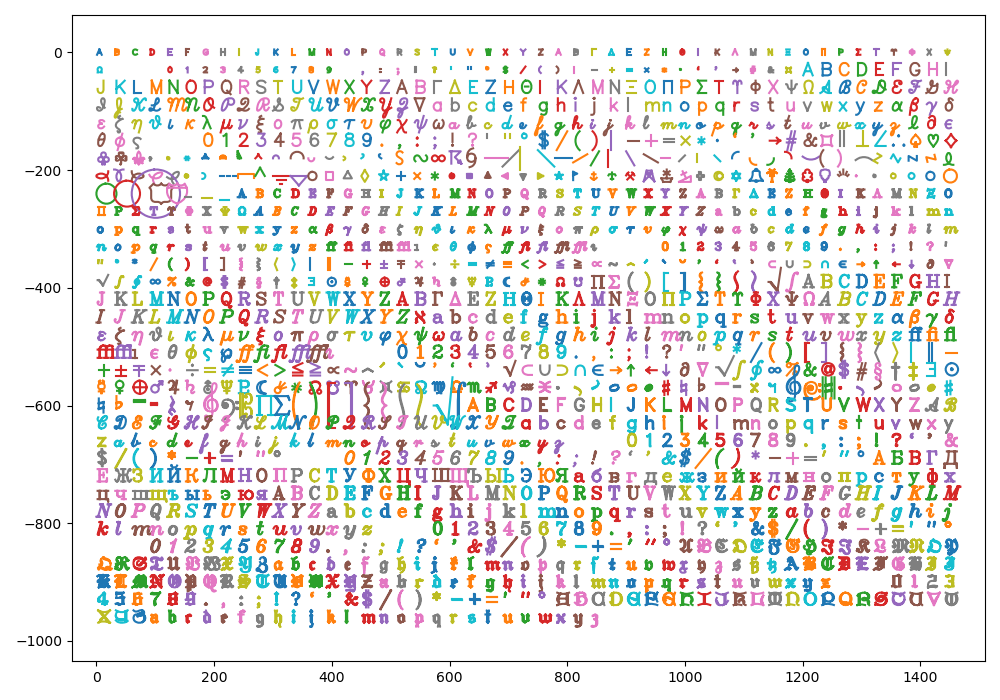

In [112]:
close('all')
figsize(10, 7)
axis('equal')

xp = 0
yp = 0
stp = 30
for k in sorted(glyphs.keys()):
    r = draw(k, xp, yp)
    xp += stp
    if (xp > stp * 48):
        xp = 0
        yp -= stp
tight_layout()

# Load all font mappings

In [3]:
maps = {}
for fn in glob("ascii-mapping/*.hmp"):
    with open(fn) as f:
        dat = expand_range(f.read(-1))
    fn_ = fn.split('/')[-1][:-4]
    maps[fn_] = dat

maps.keys()

dict_keys(['romanc', 'scriptc', 'romancs', 'greekcs', 'gothitt', 'greeks', 'romanp', 'italiccs', 'romant', 'scripts', 'romand', 'gothgrt', 'greekp', 'italict', 'italicc', 'romans', 'greekc', 'gothgbt', 'cyrilc'])

# Plot index sheets

<IPython.core.display.Javascript object>


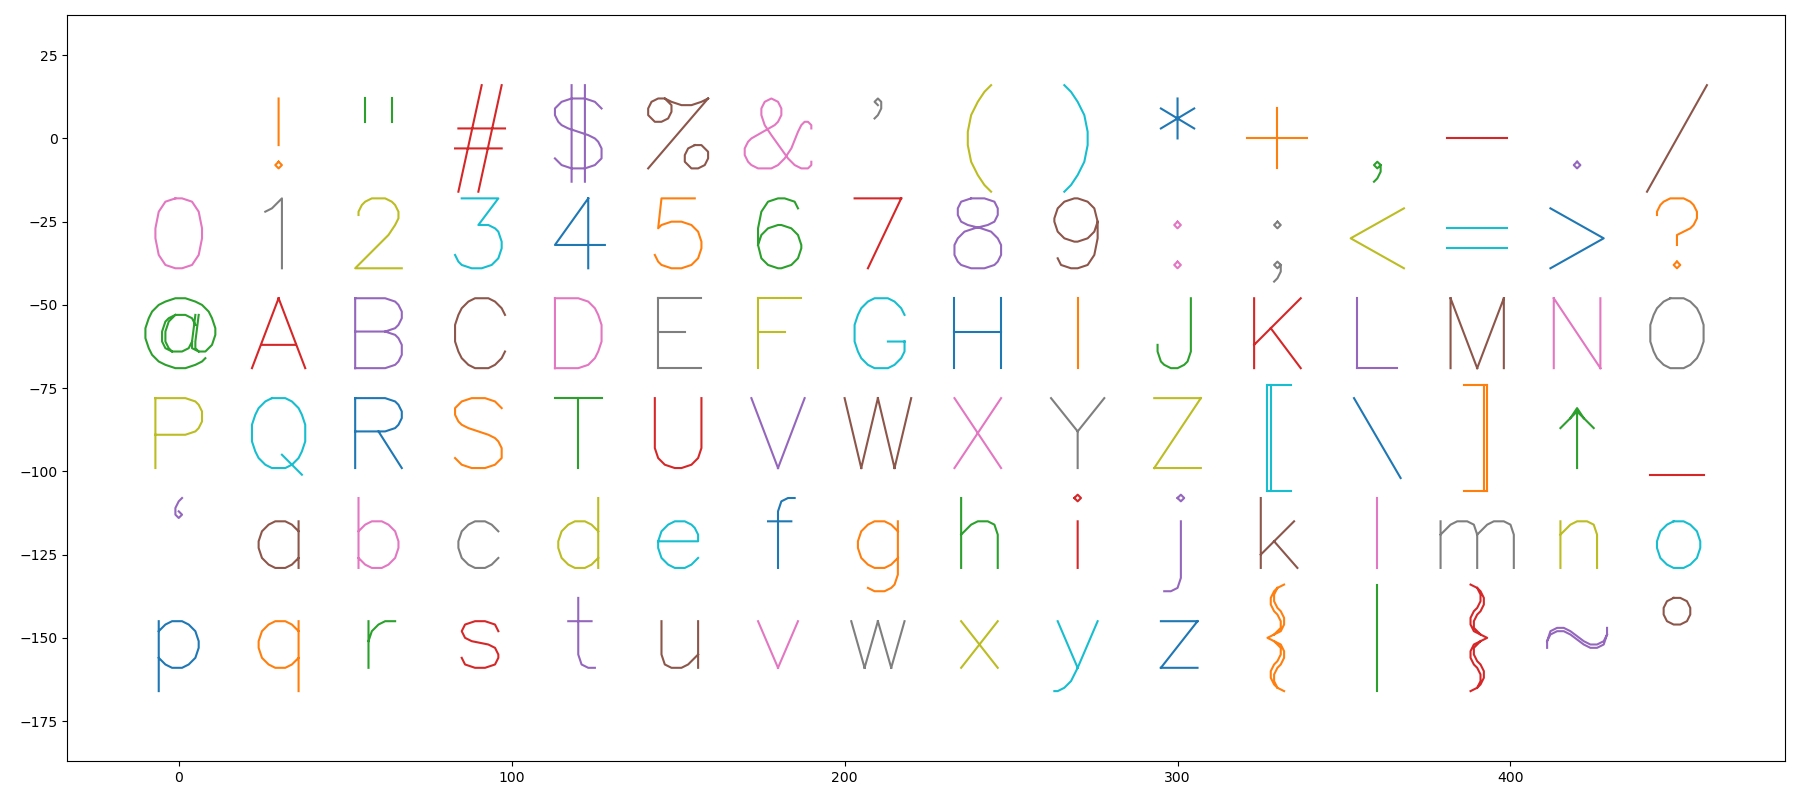

In [190]:
for m in maps.keys():
#     m = 'romans'
    figure()
    figsize(18, 8)
    axis('equal')
    tight_layout()

    xp = 0
    yp = 0
    stp = 30
    for k in maps[m]:
        r = draw(k, xp, yp)
        xp += stp
        if (xp >= stp * 16):
            xp = 0
            yp -= stp
#     break
    savefig(f'ascii-mapping/{m}.png')

# Test spacing between glyphs

The cursor is at the left edge of the glyph.

We move by -l to reach the center

We draw the glyph

We move by r to reach the right edge of the glyph

<IPython.core.display.Javascript object>


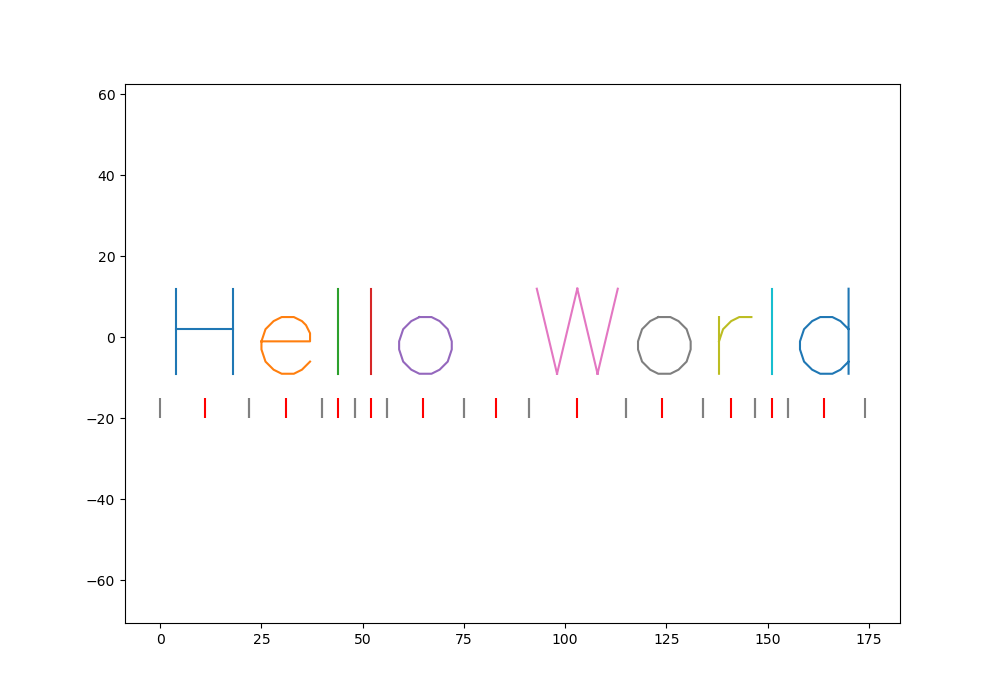

In [120]:
close('all')
axis('equal')

m = maps['romans']

x_o = 0
for c in "Hello World":
    r = draw(m[ord(c) - 0x20], x_o, 0, bb=True)
    x_o += r

# Too big glyphs for 6 bit

[906, 907, 1411, 2267, 2330, 2380, 2381, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412]


<IPython.core.display.Javascript object>


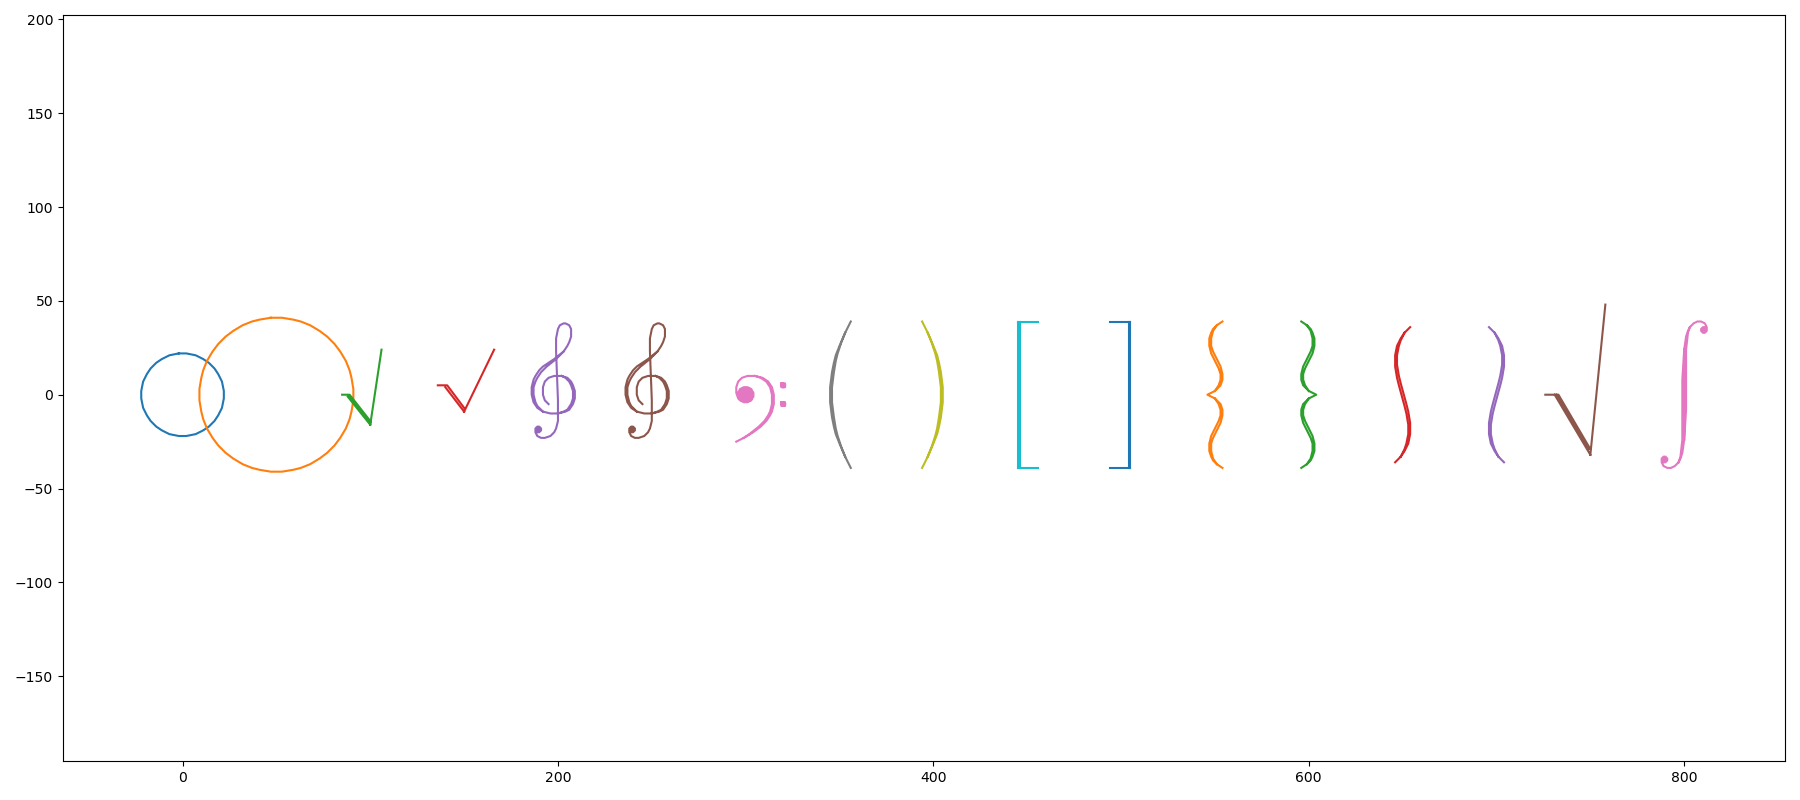

In [163]:
bgs = []
for k, v in glyphs.items():
    x = v.copy()
    x[x == -50] = 0
    if amax(x) > 21 or amin(x) < -20:
        bgs.append(k)
print(bgs)

close('all')
axis('equal')

xp = 0
yp = 0
stp = 50
for k in bgs:
    r = draw(k, xp, yp)
    xp += stp
    if (xp > stp * 16):
        xp = 0
        yp -= stp
tight_layout()

# C-code generation

In [4]:
def print_table(vals, w=24, w_v=3, f=None):
    ll = len(vals) - 1
    for i, g in enumerate(vals):
        if i > 0 and (i % w) == 0:
            print(file=f)
        print(f'{g:{w_v}d}', end='', file=f)
        if i < ll:
            print(',', end='', file=f)
    print('\n};\n', file=f)

def print_tables(name, f=None):
    all_glyphs = []
    g_lens = []
    for gid in maps[name]:
        all_glyphs += glyphs[gid].tolist()
        g_lens.append(len(glyphs[gid]))
    all_glyphs = array(all_glyphs, dtype=int8)

    print(f'static const int8_t h_{km}_glyphs[{len(all_glyphs)}] = {{', file=f)
    print_table(all_glyphs, 24, 3, f=f)

    g_inds = cumsum(g_lens)
    print(f'static const uint16_t h_{km}_inds[{len(g_inds)}] = {{', file=f)
    print_table(g_inds, 16, 5, f=f)

In [6]:
to_export = [
#     'cyrilc',
    'gothgbt',
    'gothgrt',
    'gothitt',
#     'greekc',
#     'greekcs',
#     'greekp',
#     'greeks',
    'italicc',
    'italiccs',
    'italict',
    'romanc',
    'romancs',
    'romand',
    'romanp',
    'romans',
    'romant',
    'scriptc',
    'scripts'
]

In [24]:
with open("../src/font_data.c", 'w') as f:
    print('#include "font_data.h"\n', file=f)
    for km in to_export:
        print_tables(km, f=f)
        print(f'''\
font_t f_{km} = {{
    .font_type = FONT_TYPE_LIN,
    .glyphs = h_{km}_glyphs,
    .inds = h_{km}_inds
}};
''', file=f)

    # Add the ARC font
    a_dat = load('arc_data.npz')
    arc_glyphs = a_dat['glyphs']
    arc_inds = a_dat['g_inds']
    print(f'static const int8_t arc_glyphs[{len(arc_glyphs)}] = {{', file=f)
    print_table(arc_glyphs, f=f)

    print(f'static const uint16_t arc_inds[{len(arc_inds)}] = {{', file=f)
    print_table(arc_inds, 16, 5, f=f)

    # arc-font struct
    print(f'''\
font_t f_arc = {{
    .font_type = FONT_TYPE_ARC,
    .glyphs = arc_glyphs,
    .inds = arc_inds
}};
''', file=f)

    # index table of all fonts    
    print('font_t* f_all[] = {', file=f)
    for km in to_export + ['arc']:
        print(f'  &f_{km},', file=f)
    print('};', file=f)
        
with open("../src/font_data.h", 'w') as f:
    print('''\
#ifndef FONT_DATA_H
#define FONT_DATA_H
#include <stdint.h>
#include <font_draw.h>

// gothgr  Gothic German
// gothgb  Gothic English
// gothit  Gothic Italian

// p       Plain (very small, no lower case)
// s       Simplex (plain, normal size, no serifs)
// d       Duplex (normal size, no serifs, doubled lines)
// c       Complex (normal size, serifs, doubled lines)
// t       Triplex (normal size, serifs, tripled lines)
// cs      Complex Small (Complex, smaller than normal size)
''', file=f)
    print(f'#define N_FONTS {len(to_export) + 1}\n', file=f)
    
    for i, km in enumerate(to_export + ['arc']):
        s = f'extern font_t f_{km};'
        print(f'{s:<32s}  // {i}', file=f)
    
    print('\nextern font_t* f_all[];\n', file=f)
    print('#endif', file=f)

lengt 2 means there is only the left and right value and nothing to draw, eg space

In [242]:
def get_inds(c):
    ''' generate the start and end indices into the glyph table '''
    if c <= 0:
        return 0, start_inds[0]
    return start_inds[c - 1], start_inds[c]